In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/test_data.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/train_data.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/VariableDescription.csv
/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/sample_submission.csv


In [2]:
#Configure necessary imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ins = pd.read_csv('/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/train_data.csv')

In [3]:
#Inspecting the data
ins.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


From the onset there are numerous issues with the data that have to be dealt with prior to EDA and model building. The first thing we will be taking care of is converting categorical columns into dummy variables.

In [4]:
# Encoding Categorical data with discrete numerical values
to_num = {'V':1,'N':0,'O':0,'U':1,'R':0}
ins.iloc[:,[4,5,6,7]]  =  ins.iloc[:,[4,5,6,7]].applymap(to_num.get)
ins.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,0,1,1.0,1,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,1,0,0.0,0,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,0,1,1.0,1,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,1,1,1.0,1,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,1,0,0.0,0,680.0,1,1800.0,3,1053,0



 Now that we'vw coded the categorical columns we can proceed to the **NumberOfWindows** column which consists of missing values

In [5]:
ins.NumberOfWindows.value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

We assume that buildings with greater than 10 windows have exactly 10 windows for the sake of model simplicity before proceeding with String substituion. We will also convert the DateofOccupancy column to Int64 since years are best captured by integers.

In [6]:
#Conducting String replacement to convert the NumberOfWindows column to int64
ins.NumberOfWindows = ins.NumberOfWindows.str.replace(".","0")
ins.NumberOfWindows = ins.NumberOfWindows.str.replace(">=10","10")
ins.NumberOfWindows = ins.NumberOfWindows.astype('int64')
ins.NumberOfWindows.value_counts()

0     3551
4      939
3      844
5      639
2      363
6      306
7      211
8      116
1       75
10      67
9       49
Name: NumberOfWindows, dtype: int64

At this point in the Data Cleaning stage, we've still got missing values, so we take a look via the .info() method at exactly which columns we're going to be working on.

In [7]:
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   int64  
 5   Building_Fenced     7160 non-null   int64  
 6   Garden              7153 non-null   float64
 7   Settlement          7160 non-null   int64  
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   int64  
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 783.2+ KB


The code for imputation of missing values to complete the dataset is below:

In [8]:
#Imputing missing values, 0 for binary categorical columns, column mode for discrete columns
ins.Garden = ins.Garden.fillna(0)
ins['Building Dimension'] = ins['Building Dimension'].fillna(0)
ins.Date_of_Occupancy = ins.Date_of_Occupancy.fillna(1960)
ins.Date_of_Occupancy = ins.Date_of_Occupancy.astype('int64')
ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   int64  
 5   Building_Fenced     7160 non-null   int64  
 6   Garden              7160 non-null   float64
 7   Settlement          7160 non-null   int64  
 8   Building Dimension  7160 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   7160 non-null   int64  
 11  NumberOfWindows     7160 non-null   int64  
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 783.2+ KB


Before we get to the ML model, some basic EDA is in order. Since we're dealing with Insurance Claims for properties as the Predictor in this case, it would be a good idea to look at the distribution of how old these buildings are via the **Date_of_Occupancy** column

Text(0, 0.5, 'Count')

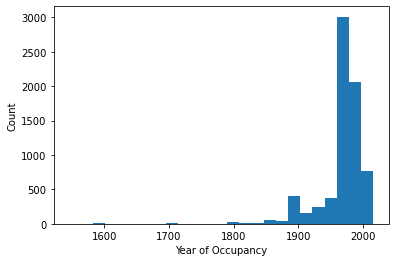

In [9]:
plt.hist(ins['Date_of_Occupancy'],bins=25)
plt.xlabel('Year of Occupancy')
plt.ylabel('Count')

We can see that a good chunk of our buildings are on the newer side built in the second half of the twentieth century with a few outliers. It would be a good idea to look at the spread of the outliers via a categorical strip plot.

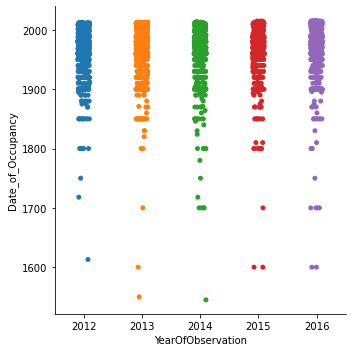

In [10]:
sns.catplot('YearOfObservation','Date_of_Occupancy',data = ins)


We see the presence of a dozen or so outliers from the seventeenth and eighteenth centuries.

Lastly prior to the regression, it would be useful to take a look at some of the other caterogical variables like Residential, Building Painted etc. to capture any chronological trends in the Insurance Pool

In [11]:
import numpy as np
t = ins[['YearOfObservation','Residential',
       'Building_Painted', 'Building_Fenced']].groupby('YearOfObservation').agg([np.sum])

t

,Residential,Building_Painted,Building_Fenced
,sum,sum,sum
YearOfObservation,,,
2012,620,1339,1065
2013,551,1339,948
2014,423,1038,646
2015,302,850,478
2016,291,816,415


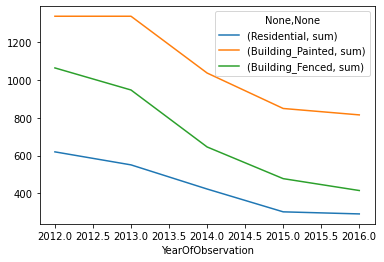

In [12]:
t.plot()

We can see a downward trend in Residential buildings being insured as well as painted and fenced buildings being insured. This is likely due to the former drop in residential buildings being insured or the Insurance firm taking on more risk.

The final step in the analysis would be to further split the training data into test and train data and fitting a ***Logistic Regression model*** to it. For more interpretable coefficients, I will not be adding Regularization to this model.

In [13]:
#Splitting Training Data into further train and test sets
X = ins.iloc[:,1:12]
y = ins.Claim

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2,random_state = 2)

In [14]:
#Model training and evaluation
lr = LogisticRegression(C = 1,max_iter = 3000,class_weight = 'balanced')
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[881, 254],
       [128, 169]])

In [15]:
accuracy_score(y_test,y_pred)

0.7332402234636871

In [16]:
roc_auc_score(y_test,y_pred)

0.6726175113840313

With the model being about two thirds accurate we take a look at some of the coefficeints to interpret the odds before proceeding with processing and predicting the test data

In [17]:

coefs = dict(zip(X_train,lr.coef_.reshape(-1,1)))
coefs = pd.DataFrame(coefs)
coefs = coefs.T
coefs.columns = ['Odds']
coefs.Odds = np.exp(coefs.Odds)
coefs

,Odds
YearOfObservation,1.000216
Insured_Period,2.047617
Residential,1.021871
Building_Painted,0.884577
Building_Fenced,1.282532
Garden,1.268736
Settlement,1.271514
Building Dimension,1.000288
Building_Type,1.235670
Date_of_Occupancy,0.998549


We see here that fenced, buildings with gardens are more likey to make a claim, also the odds of filing an insurance claim are atleast doubled for claimants who've insured the building the entire time that they've occupied it.

Lastly we import the test data and compile our results in the result dataframe as specified by the sample

In [18]:
inst = pd.read_csv("/kaggle/input/ds-nigeria-2019-challenge-insurance-prediction/test_data.csv")
inst.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [19]:
#Cleaning the Data as was done in the test set
inst.iloc[:,[4,5,6,7]]  =  inst.iloc[:,[4,5,6,7]].applymap(to_num.get)
inst.NumberOfWindows = inst.NumberOfWindows.str.replace(".","0")
inst.NumberOfWindows = inst.NumberOfWindows.str.replace(">=10","10")
inst.NumberOfWindows = inst.NumberOfWindows.astype('int64')

inst.Garden = inst.Garden.fillna(0)
inst['Building Dimension'] = inst['Building Dimension'].fillna(0)
inst.Date_of_Occupancy = inst.Date_of_Occupancy.fillna(1960)

#Assigning new explanatory variables to fit the model
X_test1 = inst.iloc[:,1:12]

#Predicting the requisite values
y_pred1 = lr.predict(X_test1)

#Creating the result dataframe
result = pd.DataFrame(zip(inst['Customer Id'],y_pred1))
result.columns = ['Client','Claim']
result = result.set_index('Client')

In [20]:
result

,Claim
Client,
H11920,0
H11921,0
H9805,0
H7493,0
H7494,0
...,...
H11583,0
H11720,0
H11721,0
